### Environment setup and downloading the dataset

In [1]:
!pip install -q --upgrade selectivesearch
import selectivesearch
from google.colab import files
files.upload() # upload kaggle.json file which you can get 
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

Saving kaggle.json to kaggle.json
kaggle.json
 96% 353M/367M [00:04<00:00, 75.5MB/s]
100% 367M/367M [00:04<00:00, 90.4MB/s]


In [2]:
%load_ext autoreload
%autoreload 2

In [81]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.ops import RoIPool
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

from pathlib import Path
from tqdm import tqdm
import time, copy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# loading the data csv file
IMAGES_ROOT = '/content/images/images'
DF_RAW = pd.read_csv('/content/df.csv')
DF_RAW.head(2)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.90875,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.7950,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.69750,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.6975,0.659167,0.141604,0.241855,0.352130,0.437343


#### Images dataset
- image
- bounding boxes
- class

In [5]:
class Images(Dataset):
  def __init__(self, df=DF_RAW, image_folder=IMAGES_ROOT):
    self.root = image_folder
    self.df = df
    self.unique_images = df['ImageID'].unique()
  
  def __len__(self):
    return len(self.unique_images)

  def __getitem__(self, idx):
    image_id = self.unique_images[idx]
    image_path = f'{self.root}/{image_id}.jpg'
    image = cv2.imread(image_path, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    sub_df = self.df[self.df['ImageID'] == image_id]
    boxes = sub_df[['XMin', 'YMin', 'XMax', 'YMax']].values
    # convert scaled values
    boxes = (boxes*np.array([w, h, w, h])).astype(np.uint16)
    classes = sub_df['LabelName'].values.tolist()
    return image, boxes, classes, image_path

In [6]:
ds = Images()
img, bbs, clss, img_path = ds[23]
img.shape, bbs.shape, len(clss)

((192, 256, 3), (4, 4), 4)

In [7]:
# draw boudning boxes
def show(img, bbs, texts, sz=7):
  """A function to show an image with its boudning boxes"""
  n_img = img.copy()
  for idx, b in enumerate(bbs):
    start_point = (b[0], b[1])
    end_point = (b[2], b[3])
    n_img = cv2.rectangle(n_img, start_point, end_point, (0, 255, 0), 1)
    cv2.putText(n_img, texts[idx], (b[0], b[1]-2), cv2.FONT_HERSHEY_DUPLEX, 0.7, (255, 0, 0), 1)
  plt.figure(figsize = (sz, sz))
  plt.imshow(n_img)

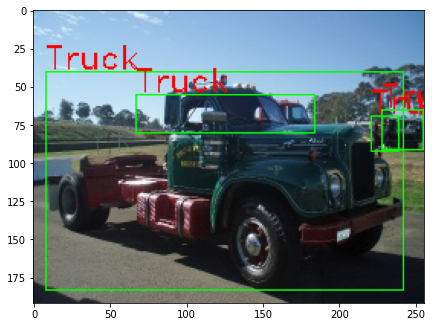

In [8]:
show(img, bbs, clss)

In [9]:
def extract_candidates(img):
  '''A function to extract region proposals from an image'''
  img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
  img_area = np.prod(img.shape[:2])
  candidates = [] # filtering out candidates
  for r in regions:
    if r['rect'] in candidates: continue
    if r['size'] < (0.05*img_area): continue
    if r['size'] > (1*img_area): continue
    candidates.append(r['rect'])
  return candidates

def extract_iou(boxA, boxB, epsilon=1e-5):
  """A function to calculate the iou betweeb 2 boxes"""
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  width = (x2 - x1)
  height = (y2 - y1)
  if width<0 or height < 0:
    return 0.0
  overlap_area = width * height
  a_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  b_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  combined_area = a_area + b_area - overlap_area
  iou = overlap_area / combined_area
  return iou  

In [82]:
def prepare_data(ds, n_samples=500):
  FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
  N = n_samples
  for idx, (im, bbs, labels, fpath) in enumerate(tqdm(ds, total=N, desc='Preparing data')):
      if(idx==N):
          break
      H, W, _ = im.shape
      candidates = extract_candidates(im)
      # turn candidates to x1, y1, x2, y2 instead of x1, y1, w, h
      candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])
      ious, rois, clss, deltas = [], [], [], []
      #calculate iou between candidates and every bbs in our dataset and transpose
      ious = np.array([[extract_iou(candidate, _bb) for candidate in candidates] for _bb in bbs]).T
      for jdx, candidate in enumerate(candidates):
        cx, cy, cX, cY = candidate
        candidate_ious = ious[jdx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x, _y, _X, _Y = bbs[best_iou_at] # get the best bb match to this candidate based on iou
        if best_iou > 0.3: 
          clss.append(labels[best_iou_at])
        else:
          clss.append('background')
        # calculate the deltas and scale them
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W, H, W, H])
        deltas.append(delta)
        rois.append(candidate / np.array([W, H, W, H]))
      FPATHS.append(fpath)
      IOUS.append(ious)
      ROIS.append(rois)
      CLSS.append(clss)
      DELTAS.append(deltas)
      GTBBS.append(bbs)
  FPATHS = [f'{IMAGES_ROOT}/{Path(f).stem}.jpg' for f in FPATHS] 
  return [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [83]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS = prepare_data(ds, 1000)

Preparing data: 100%|██████████| 1000/1000 [04:45<00:00,  3.50it/s]


In [84]:
import itertools
def flatten(l):
  """Takes a 2d list and flattens it"""
  return list(itertools.chain.from_iterable(l))

In [85]:
# labels dictionaray
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t, l in enumerate(targets['label'].unique())}
target2label = {t:l for l, t in label2target.items()}
background_class = label2target['background']

In [86]:
# helper functions
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def normalize_image(img):
  img = torch.tensor(img).permute(2, 0, 1)
  img = normalize(img)
  return img.to(device).float()

def decode(_y):
  _, preds = _y.max(-1)
  return preds

In [87]:
# dataset
class FRCNNDataset(Dataset):
  def __init__(self, fpaths, rois, labels, deltas, gtbbs):
    self.fpaths = fpaths
    self.gtbbs = gtbbs
    self.rois = rois
    self.labels = labels
    self.deltas = deltas
  
  def __len__(self):
    return len(self.fpaths)
  
  def __getitem__(self, idx):
    fpath = self.fpaths[idx]
    image = cv2.imread(fpath, 1)[...,::-1]
    gtbbs = self.gtbbs[idx]
    rois = self.rois[idx]
    labels = self.labels[idx]
    deltas = self.deltas[idx]
    assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
    return image, rois, labels, deltas, gtbbs, fpath
  
  def collate_fn(self, batch):
    input, rois, rixs, labels, deltas = [], [], [], [], []
    for idx in range(len(batch)):
      image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[idx]
      image = cv2.resize(image, (224, 244))
      input.append(normalize_image(image/255.)[None])
      rois.extend(image_rois)
      rixs.extend([idx]*len(image_rois))
      labels.extend([label2target[c] for c in image_labels])
      deltas.extend(image_deltas)
    input = torch.cat(input).to(device)
    rois = torch.Tensor(rois).float().to(device)
    rixs = torch.Tensor(rixs).float().to(device)
    labels = torch.Tensor(labels).long().to(device)
    deltas = torch.Tensor(deltas).float().to(device)
    return input, rois, rixs, labels, deltas

In [88]:
n_train = 9*len(FPATHS)//10
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)
dataloaders = {'train': train_loader,
                'valid': test_loader}

In [89]:
# FRCNN Model
class FRCNN(nn.Module):
  def __init__(self):
    super().__init__()
    backend = models.vgg16_bn(pretrained=True)
    for param in backend.features.parameters():
      param.requires_grad = False
    self.seq = nn.Sequential(*list(backend.features.children())[:-1]) # skip the last pooling layer
    # roipool extracts 7x7 output and scales proposals from 224 to 14 (size of our feature map)
    self.roipool = RoIPool(7, spatial_scale=14/224)
    feature_dim = 512*7*7
    self.classifier = nn.Linear(feature_dim, len(label2target))
    self.regressor = nn.Sequential(
        nn.Linear(feature_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 4),
        nn.Tanh()
    )

  def forward(self, input, rois, ridx):
    res = self.seq(input)
    rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
    res = self.roipool(res, rois)
    feat = res.view(len(res), -1)
    cls_score = self.classifier(feat)
    bbox = self.regressor(feat)
    return cls_score, bbox


In [90]:
clss_criterion = nn.CrossEntropyLoss()
regr_criterion = nn.L1Loss()
def criterion(probs, _deltas, labels, deltas):
  
  detection_loss = clss_criterion(probs, labels)
  idxs, = torch.where(labels != background_class)
  _deltas = _deltas[idxs]
  deltas = deltas[idxs]
  lmb = 10.0
  if len(idxs)>0:
    regression_loss = regr_criterion(_deltas, deltas)
    return detection_loss + lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
  else:
    regression_loss = 0
    return detection_loss + lmb * regression_loss, detection_loss.detach(), regression_loss

In [91]:
def train_model(model, criterion, optimizer, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')
  train_losses = []
  valid_losses = []

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print('-'*10)

    # train and val phases
    for phase in ['train', 'valid']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_loc_loss = 0.0
      running_reg_loss = 0.0
      running_acc = 0.0
      # iterate over data
      for idx, inputs in enumerate(dataloaders[phase]):
        input, rois, rixs, clss, deltas = inputs

        # zero the parameters gradients
        optimizer.zero_grad()

        # forward
        # tack history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          _clss, _deltas = model(input, rois, rixs)
          loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
          accs = clss == decode(_clss)
          # backward + optimize if only in train
          if phase == 'train':
            loss.backward()
            optimizer.step()

        
        # stats
        running_loss += loss.item()
        running_loc_loss += loc_loss
        running_reg_loss += regr_loss
        running_acc += accs.cpu().numpy().mean()


      
      epoch_loss = running_loss / (idx+1)
      epoch_loc_loss = running_loc_loss / (idx+1)
      epoch_reg_loss = running_reg_loss / (idx+1)
      epoch_acc = running_acc / (idx+1)
      print(f'{phase} Total Loss: {epoch_loss:.4f} classification loss: {epoch_loc_loss:.4f} Regression loss: {epoch_reg_loss:.4f} Accuracy: {epoch_acc:.2f}%')

      if phase == 'train':
        train_losses.append(epoch_loss)
      else:
        valid_losses.append(epoch_loss)

      # keep the best model
      if phase == 'valid' and epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
  print(f'Best val Loss: {best_loss:.4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  # save model's best weight to desk
  torch.save(model.state_dict(), '02.pth')
  return model, train_losses, valid_losses

In [92]:
model = FRCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [93]:
model, train_losses, valid_losses = train_model(model, criterion, optimizer, 10)

Epoch 0/9

----------

train Total Loss: 1.7657 classification loss: 0.7442 Regression loss: 0.1022 Accuracy: 0.70%

valid Total Loss: 1.4431 classification loss: 0.5820 Regression loss: 0.0861 Accuracy: 0.76%

Epoch 1/9

----------

train Total Loss: 1.3303 classification loss: 0.5795 Regression loss: 0.0751 Accuracy: 0.77%

valid Total Loss: 1.4141 classification loss: 0.5613 Regression loss: 0.0853 Accuracy: 0.78%

Epoch 2/9

----------

train Total Loss: 1.1269 classification loss: 0.5160 Regression loss: 0.0611 Accuracy: 0.80%

valid Total Loss: 1.3626 classification loss: 0.5558 Regression loss: 0.0807 Accuracy: 0.78%

Epoch 3/9

----------

train Total Loss: 1.0057 classification loss: 0.4742 Regression loss: 0.0532 Accuracy: 0.82%

valid Total Loss: 1.4178 classification loss: 0.5550 Regression loss: 0.0863 Accuracy: 0.78%

Epoch 4/9

----------

train Total Loss: 0.9127 classification loss: 0.4428 Regression loss: 0.0470 Accuracy: 0.84%

valid Total Loss: 1.3741 classification loss: 0.5563 Regression loss: 0.0818 Accuracy: 0.78%

Epoch 5/9

----------

train Total Loss: 0.8475 classification loss: 0.4178 Regression loss: 0.0430 Accuracy: 0.85%

valid Total Loss: 1.3520 classification loss: 0.5586 Regression loss: 0.0793 Accuracy: 0.78%

Epoch 6/9

----------

train Total Loss: 0.7885 classification loss: 0.3970 Regression loss: 0.0392 Accuracy: 0.86%

valid Total Loss: 1.3349 classification loss: 0.5615 Regression loss: 0.0773 Accuracy: 0.78%

Epoch 7/9

----------

train Total Loss: 0.7438 classification loss: 0.3792 Regression loss: 0.0365 Accuracy: 0.87%

valid Total Loss: 1.3902 classification loss: 0.5645 Regression loss: 0.0826 Accuracy: 0.78%

Epoch 8/9

----------

train Total Loss: 0.7054 classification loss: 0.3638 Regression loss: 0.0342 Accuracy: 0.88%

valid Total Loss: 1.3332 classification loss: 0.5677 Regression loss: 0.0766 Accuracy: 0.78%

Epoch 9/9

----------

train Total Loss: 0.6703 classification loss: 0.3501 Regression loss: 0.0320 Accuracy: 0.88%

valid Total Loss: 1.3358 classification loss: 0.5709 Regression loss: 0.0765 Accuracy: 0.78%

Training complete in 1m 48s

Best val Loss: 1.3332

In [94]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
def plot_losses(n_epochs, train_losses, valid_losses):
  epochs = np.arange(n_epochs)+1
  plt.plot(epochs, train_losses, 'bo', label='Training loss')
  plt.plot(epochs, valid_losses, 'r', label='Validation loss')
  plt.title('Training and Test loss over increasing epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid('off')
  plt.show()

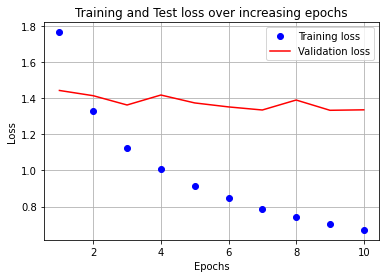

In [96]:
plot_losses(10, train_losses, valid_losses)

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = normalize_image(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        model.eval()
        probs, deltas = model(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    
    bbs = bbs.astype(np.uint16)
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

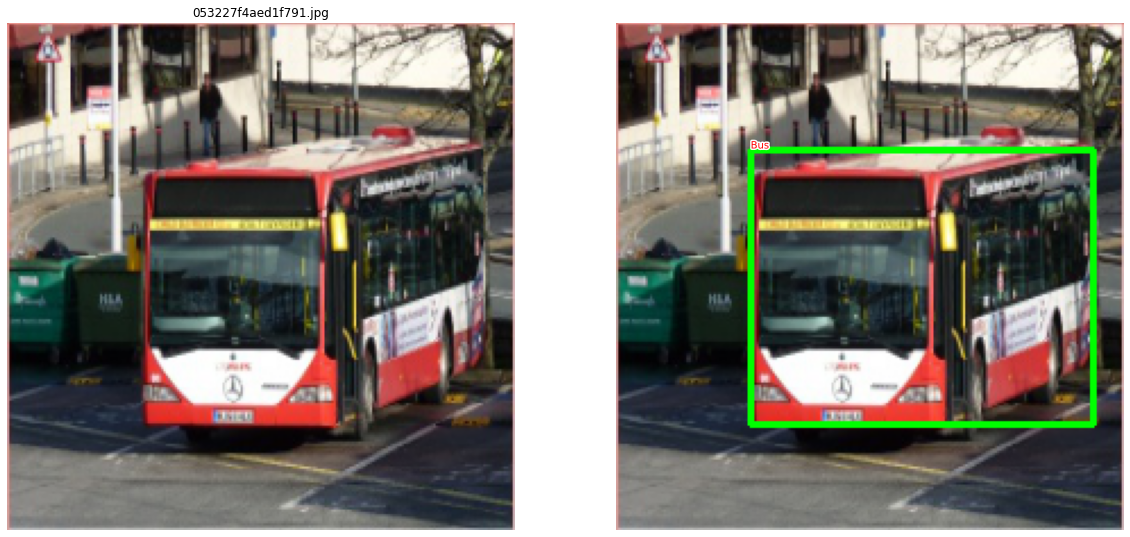

In [110]:
test_predictions(test_ds[2][-1])